# Implementing full space-time FEM in FEniCS with Final Condition for Velocity

In [1]:
try:
    import dolfin
except ImportError:
    # FEniCS installation on Google Colab
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Full space-time Finite Element Method
Now that you have understood how the Poisson problem can be solved in FEniCS, you will now need to extend this to a full space-time code. For this you will need to solve the wave equation in one spatial dimension, which is given by
$$
\partial_{tt} u - \partial_{xx} u = f \qquad \forall x \in \Omega := (0,1),\, t \in I := \left(0,4\right).
$$
Converting this into a first order system in time yields
$$
\partial_{t} v - \partial_{xx} u = f, \\
\partial_t u = v.
$$
The manufactured solution is given by $u(x,t) := \sin(t)x(1-x)$ and $v(x,t) = \cos(t)x(1-x)$.
On all space-time boundaries for $t < T := 4$, we prescribe Dirichlet boundary conditions using the analytical solution and the right hand side $f$ is being derived by plugging the analytical solution into the PDE.

The right hand side is given by 
$$
f(x,t) = (2-x(1-x))\sin(t).
$$

The space-time variational formulation is: Find $(u,v) \in V^2$ such that
$$
\int_{\Omega \times I} \partial_t v \varphi^u + \partial_x u \partial_x \varphi^u\ \mathrm{d}(x,t) + \int_{\Omega \times I} \partial_t u \varphi^v - v \varphi^v\ \mathrm{d}(x,t) = \int_{\Omega \times I} f\varphi^u\ \mathrm{d}(x,t) \qquad \forall (\varphi^u, \varphi^v) \in V^2.
$$
But instead of the two initial conditions
$$
u(x,0) = u^0(x), \\
v(x,0) = v^0(x),
$$
we now have
$$
v(x,0) = v^0(x), \\
v(x,T) = v^T(x).
$$

Example solution:


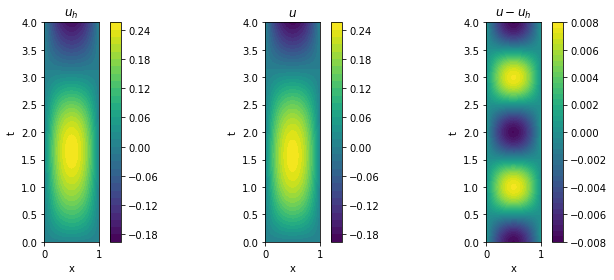

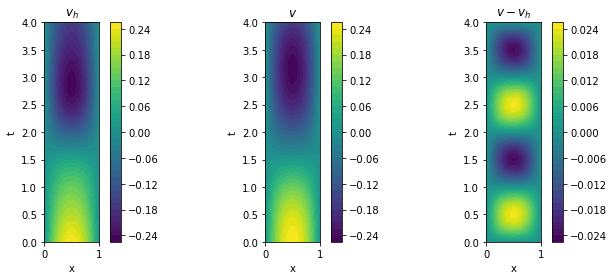

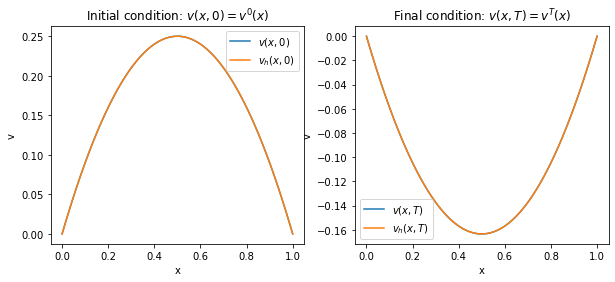

L2 error for N_x= 100, N_t=1000: 2.5318e-02


Space-time refinement:
L2 error for N_x=  50, N_t=  50: 7.7302e-02
L2 error for N_x= 100, N_t= 100: 7.7526e-02
L2 error for N_x= 200, N_t= 200: 7.7180e-02
L2 error for N_x= 400, N_t= 400: 7.7138e-02


Space refinement:
L2 error for N_x= 100, N_t=  50: 7.8989e-02
L2 error for N_x= 200, N_t=  50: 7.9097e-02
L2 error for N_x= 400, N_t=  50: 7.9198e-02
L2 error for N_x= 800, N_t=  50: 7.9225e-02


Time refinement:
L2 error for N_x=  50, N_t= 100: 7.1580e-02
L2 error for N_x=  50, N_t= 200: 5.5610e-02
L2 error for N_x=  50, N_t= 400: 3.1813e-02
L2 error for N_x=  50, N_t= 800: 1.5980e-02
L2 error for N_x=  50, N_t=1600: 1.0221e-02
L2 error for N_x=  50, N_t=3200: 8.6135e-03
L2 error for N_x=  50, N_t=6400: 8.1999e-03


In [2]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

set_log_active(False) # turn off FEniCS logging

def solve_wave_final(n_space, n_time, _plot=False):
    # define space-time mesh
    t0    = 0.# start time
    T     = 4 # end time
    x_min = 0.# left end of spatial domain
    x_max = 1.# right end of spatial domain

    # coordinates: (x,t)
    mesh = RectangleMesh(Point(x_min, t0), Point(x_max, T), n_space, n_time)

    element = {
        "u": FiniteElement("Lagrange", mesh.ufl_cell(), 1),
        "v": FiniteElement("Lagrange", mesh.ufl_cell(), 1),
    }
    V = FunctionSpace(mesh, MixedElement(*element.values())) 

    # Analytical solution U is used as Dirichlet BC for x ∈ ∂Ω = {x_min, x_max} or t = t0
    U = Expression(('sin(x[1])*x[0]*(1.-x[0])', 'cos(x[1])*x[0]*(1.-x[0])'), degree=2)
    bc_space = DirichletBC(V.sub(0), Expression('sin(x[1])*x[0]*(1.-x[0])', degree=2), lambda x, on_boundary: (near(x[0], x_min) or near(x[0], x_max)) and on_boundary)
    bc_time = DirichletBC(V.sub(1), Expression('cos(x[1])*x[0]*(1.-x[0])', degree=2), lambda x, on_boundary: (near(x[1], t0) or near(x[1], T)) and on_boundary)
    bc = [bc_space, bc_time]

    # Define variational problem
    f = Expression('sin(x[1])*(2.-x[0]*(1.-x[0]))', degree=2)
    u, v = split(TrialFunction(V))
    phi_u, phi_v = TestFunctions(V)
    a = grad(v)[1]*phi_u*dx + grad(u)[0]*grad(phi_u)[0]*dx + grad(u)[1]*phi_v*dx - v*phi_v*dx
    L = f*phi_u*dx

    # Solve
    U_h = Function(V)
    solve(a == L, U_h, bc)
    u_h, v_h = split(U_h)

    if _plot:
        # Plot u
        fig, axes = plt.subplots(1, 3, figsize=(10, 4))  

        plt.subplot(1, 3, 1)
        c = plot(u_h, title='$u_h$')
        plt.xlabel("x")
        plt.ylabel("t")
        cbar = plt.colorbar(c, orientation='vertical')

        plt.subplot(1, 3, 2)
        u_proj = project(U[0], FunctionSpace(mesh, "CG", 1))
        c = plot(u_proj, title='$u$')
        plt.xlabel("x")
        plt.ylabel("t")
        cbar = plt.colorbar(c, orientation='vertical')

        plt.subplot(1, 3, 3)
        c = plot(U[0]-u_h, title='$u - u_h$')
        plt.xlabel("x")
        plt.ylabel("t")
        cbar = plt.colorbar(c, orientation='vertical')

        plt.tight_layout()
        plt.show()

        # Plot v
        fig, axes = plt.subplots(1, 3, figsize=(10, 4))  

        plt.subplot(1, 3, 1)
        c = plot(v_h, title='$v_h$')
        plt.xlabel("x")
        plt.ylabel("t")
        cbar = plt.colorbar(c, orientation='vertical')

        plt.subplot(1, 3, 2)
        v_proj = project(U[1], FunctionSpace(mesh, "CG", 1))
        c = plot(v_proj, title='$v$')
        plt.xlabel("x")
        plt.ylabel("t")
        cbar = plt.colorbar(c, orientation='vertical')

        plt.subplot(1, 3, 3)
        c = plot(U[1]-v_h, title='$v - v_h$')
        plt.xlabel("x")
        plt.ylabel("t")
        cbar = plt.colorbar(c, orientation='vertical')

        plt.tight_layout()
        plt.show()
        
        # Plot initial and final conditions
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        x = np.linspace(x_min, x_max, 100)

        plt.subplot(1, 2, 1)
        plt.title('Initial condition: $v(x,0) = v^0(x)$')
        y = [U(x, t0)[1] for x in x]
        y_h = [U_h(x, t0)[1] for x in x]
        plt.plot(x, y, label='$v(x,0)$')
        plt.plot(x, y_h, label='$v_h(x,0)$')
        plt.xlabel("x")
        plt.ylabel("v")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title('Final condition: $v(x,T) = v^T(x)$')
        y = [U(x, T)[1] for x in x]
        y_h = [U_h(x, T)[1] for x in x]
        plt.plot(x, y, label='$v(x,T)$')
        plt.plot(x, y_h, label='$v_h(x,T)$')
        plt.xlabel("x")
        plt.ylabel("v")
        plt.legend()
        plt.show()

    print(f"L2 error for N_x={n_space:>4}, N_t={n_time:>4}: {errornorm(U, U_h, 'L2'):.4e}")
    
# example solution
print("Example solution:")
solve_wave_final(n_space=100, n_time=1000, _plot=True)

# space-time refinement convergence
print("\n\nSpace-time refinement:")
for (N_x, N_t) in [(50*pow(2,i), 50*pow(2,i)) for i in range(4)]:
    solve_wave_final(n_space=N_x, n_time=N_t, _plot=False)
    
# space refinement convergence
print("\n\nSpace refinement:")
for (N_x, N_t) in [(100*pow(2,i), 50) for i in range(4)]:
    solve_wave_final(n_space=N_x, n_time=N_t, _plot=False)
    
# time refinement convergence
print("\n\nTime refinement:")
for (N_x, N_t) in [(50, 100*pow(2,i)) for i in range(7)]:
    solve_wave_final(n_space=N_x, n_time=N_t, _plot=False)